In [ ]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar datos
df = pd.read_csv("caso4_salud_enfermedades.csv")

In [4]:

# 2. Feature Engineering sofisticado
df['obesidad'] = (df['imc'] > 30).astype(int)
df['azucar_alta'] = (df['ingesta_azucar'] > 100).astype(int)


In [28]:

# Variable ordinal para ejercicio


mapeo_frecuencia = {
    'Nunca': 0,
    '1-2 veces': 1,
    '3+ veces': 2
}

df['ejercicio_freq_num'] = df['ejercicio_frecuencia'].map(mapeo_frecuencia)


# Interacción no lineal que suele indicar riesgo metabólico
df['riesgo_metabolico'] = df['imc'] * df['ingesta_azucar'] * (1 - df['ejercicio_freq_num'])


In [29]:

# Clasificación basada en KMeans (estrategia semi no supervisada para clusterizar riesgo)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X_cluster = df[['imc', 'ingesta_azucar', 'edad']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster_riesgo'] = kmeans.fit_predict(X_scaled)


In [30]:
df['ejercicio_freq_num'].value_counts(dropna=False)

ejercicio_freq_num
1    70
2    66
0    64
Name: count, dtype: int64

In [27]:
# Revisa las columnas no numéricas
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col} →", df[col].unique()[:5])


ejercicio_frecuencia → ['Nunca' '1-2 veces' '3+ veces']


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   edad                  200 non-null    int64  
 1   imc                   200 non-null    float64
 2   fuma                  200 non-null    int64  
 3   ejercicio_frecuencia  200 non-null    object 
 4   ingesta_azucar        200 non-null    float64
 5   enfermedad_cronica    200 non-null    int64  
 6   obesidad              200 non-null    int32  
 7   azucar_alta           200 non-null    int32  
 8   ejercicio_freq_num    200 non-null    int64  
 9   riesgo_metabolico     200 non-null    float64
 10  cluster_riesgo        200 non-null    int32  
dtypes: float64(3), int32(3), int64(4), object(1)
memory usage: 15.0+ KB


In [35]:
print(df[['ingesta_azucar', 'riesgo_metabolico']].dtypes)
print(df[['ingesta_azucar', 'riesgo_metabolico']].isnull().sum())
print(df[['ingesta_azucar', 'riesgo_metabolico']].head())


ingesta_azucar       float64
riesgo_metabolico    float64
dtype: object
ingesta_azucar       0
riesgo_metabolico    0
dtype: int64
   ingesta_azucar  riesgo_metabolico
0           137.0             2945.5
1            72.8             1310.4
2           131.9                0.0
3            96.9            -3488.4
4           116.6                0.0


In [36]:
# Opcional: eliminar o corregir valores negativos si no son válidos
df['riesgo_metabolico'] = df['riesgo_metabolico'].apply(lambda x: x if x >= 0 else 0)


[LightGBM] [Info] Number of positive: 29, number of negative: 111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207143 -> initscore=-1.342234
[LightGBM] [Info] Start training from score -1.342234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Description,Value
0,Session id,777
1,Target,enfermedad_cronica
2,Target type,Binary
3,Original data shape,"(200, 11)"
4,Transformed data shape,"(200, 2)"
5,Transformed train set shape,"(140, 2)"
6,Transformed test set shape,"(60, 2)"
7,Ignore features,1
8,Numeric features,8
9,Categorical features,1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7571,0.6125,0.1000,0.2333,0.1333,0.0312,0.0345,0.1770
et,Extra Trees Classifier,0.7571,0.6125,0.1000,0.2333,0.1333,0.0312,0.0345,0.0690
gbc,Gradient Boosting Classifier,0.7571,0.6100,0.1000,0.2333,0.1333,0.0312,0.0345,0.0690
ada,Ada Boost Classifier,0.7714,0.5991,0.0000,0.0000,0.0000,-0.0360,-0.0435,0.0730
lr,Logistic Regression,0.7929,0.5903,0.0000,0.0000,0.0000,0.0000,0.0000,0.5720
nb,Naive Bayes,0.7929,0.5903,0.0000,0.0000,0.0000,0.0000,0.0000,0.0520
ridge,Ridge Classifier,0.7929,0.5903,0.0000,0.0000,0.0000,0.0000,0.0000,0.0630
qda,Quadratic Discriminant Analysis,0.7929,0.5903,0.0000,0.0000,0.0000,0.0000,0.0000,0.0340
lda,Linear Discriminant Analysis,0.7929,0.5903,0.0000,0.0000,0.0000,0.0000,0.0000,0.0380
lightgbm,Light Gradient Boosting Machine,0.7786,0.5400,0.0000,0.0000,0.0000,-0.0240,-0.0290,0.0550


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8958,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7857,0.2576,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7143,0.1364,0.0000,0.0000,0.0000,-0.1200,-0.1448
3,0.7857,0.3939,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7143,0.5758,0.0000,0.0000,0.0000,-0.1200,-0.1448
5,0.7143,0.7879,0.3333,0.3333,0.3333,0.1515,0.1515
6,0.7857,0.7273,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7857,0.7727,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7143,0.4697,0.0000,0.0000,0.0000,-0.1200,-0.1448


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


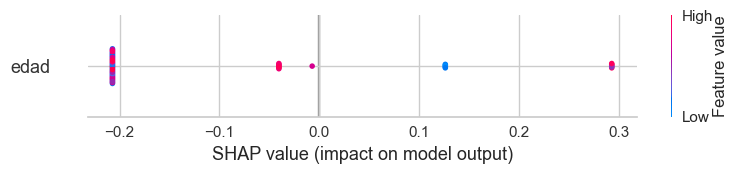

Diagnóstico proyectado:    edad  imc  fuma ejercicio_frecuencia  ingesta_azucar  obesidad  \
0    52   33     1                Nunca             130         1   

   azucar_alta  ejercicio_freq_num  riesgo_metabolico  cluster_riesgo  \
0            1                   0               4290               2   

   prediction_label  prediction_score  
0                 0               1.0  
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['edad', 'imc', 'fuma',
                                              'ingesta_azucar', 'obesidad',
                                              'azucar_alta',
                                              'ejercicio_freq_num',
                                              'riesgo_metabolico'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('c...
          

In [38]:

# 3. Configurar PyCaret con todo el nuevo feature engineering
clf = setup(data=df,
            target='enfermedad_cronica',
            session_id=777,
            ignore_features=['ejercicio_frecuencia'],
            categorical_features=['cluster_riesgo'],
            bin_numeric_features=['ingesta_azucar', 'riesgo_metabolico'],
            normalize=True,
            feature_selection=True,
            remove_multicollinearity=True,
            multicollinearity_threshold=0.8)

# 4. Comparar modelos optimizando por AUC (curva ROC balanceada)
best_model = compare_models(sort='AUC')

# 5. Ajuste fino buscando explicar más sin sobreajuste
tuned = tune_model(best_model, optimize='AUC')

# 6. Interpretación con SHAP (importantísimo en salud)
interpret_model(tuned, plot='summary')

# 7. Crear predicción simulada para una feria de salud
nuevo_caso = pd.DataFrame({
    'edad': [52],
    'imc': [33],
    'fuma': [1],
    'ejercicio_frecuencia': ['Nunca'],
    'ingesta_azucar': [130],
    'obesidad': [1],
    'azucar_alta': [1],
    'ejercicio_freq_num': [0],
    'riesgo_metabolico': [33*130*1],
    'cluster_riesgo': [2]
})
resultado = predict_model(tuned, data=nuevo_caso)
print("Diagnóstico proyectado:", resultado)

# 8. Exportar modelo para clínica móvil
save_model(tuned, 'modelo_salud_cronico_movil')
